# 0. Installing the Packages

In [1]:
! pip install pyspark
! pip install ucimlrepo
! pip install pandas
! pip install matplotlib
! pip install seaborn
! pip install scipy
! pip install numpy

# 1. Setting up Apache Spark

In [2]:
import json
from collections import defaultdict
from typing import List, Union, Optional, Tuple
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    DecisionTreeClassifier,
    LinearSVC,
    LogisticRegression,
    NaiveBayes,
    RandomForestClassifier,
    GBTClassifier,
)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler,
    Normalizer,
)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import corr
from pyspark.sql.types import IntegerType
from ucimlrepo import fetch_ucirepo

filterwarnings(action="ignore")

use_cluster = False

In [3]:
conf = pyspark.SparkConf()

if use_cluster:
    conf.setMaster("spark://127.0.0.1:7077")
else:
    conf.setMaster("local[*]")

conf.setAppName("DiabeticPatients")
conf.set("spark.authenticate", False)
conf.set("spark.dynamicAllocation.enabled", True)
# conf.set("spark.spark.executor.memory", "12g")
sc = pyspark.SparkContext(conf=conf)
sc.setLogLevel("ERROR")

25/02/03 15:31:59 WARN Utils: Your hostname, sigma resolves to a loopback address: 127.0.1.1; using 172.16.160.48 instead (on interface wlp0s20f3)
25/02/03 15:31:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/03 15:31:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In the cell above, I set up the spark config to whether on run a `local` or `cluster`. If `use_cluster` is set to
`True`, then the cluster url must be set correctly.

In [4]:
# connect to master node at the specified URL
spark = SparkSession(sc)

The `SparkSession` is the entry point to programming Spark with the Dataset and DataFrame API. I create an instance
in the above cell.

In [5]:
spark.getActiveSession()

By printing out the active session, Information about current session and app can be seen above.

----

# 2. Creating the spark dataframe from the Dataset:

In [6]:
# Fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# Data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

# Combine features and targets into a single dataframe
df = pd.concat([X, y], axis=1)

# Save the dataframe to a CSV file
df.to_csv("diabetic_data.csv", index=False)

# Metadata
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata)

# Variable information
print(diabetes_130_us_hospitals_for_years_1999_2008.variables)

{'uci_id': 296, 'name': 'Diabetes 130-US Hospitals for Years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide pro

In [7]:
df = spark.read.csv("diabetic_data.csv", header=True, inferSchema=True)
count = df.count()

print(f"Number of instances in the dataframe: {count}")
print(f"Number of features in the dataframe: {len(df.columns)}")

Number of instances in the dataframe: 101766
Number of features in the dataframe: 48


In [8]:
df.columns

['race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

By using the DataFrameReader API of the SparkSession I read the `csv` file in the specified directory.

In [9]:
df.printSchema()

root
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- m

In the cell above, I have printed out the database schema. It is obvious that there are null values in the dataframe
that needs to be dealt with.

The dataframe has `49` features with one label named `readmitted`.

---

# 3. Dataset cleaning

In [10]:
def show_column_distinct_values(
    df: pyspark.sql.DataFrame,
    col_name: str,
    sort_by_count: bool = False,
    n: int = 1000,
    show_result: bool = True,
) -> Optional[pyspark.sql.DataFrame]:
    """
    Show a list of distinct values with occurrence count of each value

    Parameters
    ----------
    df : pyspark.sql.DataFrame
        Dataframe to query from
    col_name : str
        Name of the column to query
    sort_by_count : bool, default : False
        Whether to sort the results by the occurrence count or not.
    n : int, default : 1000
        Number of distinct values to check
    show_result : bool, default : True
        Whether to show the results or return the calculated dataframe.

    Returns
    -------
    pyspark.sql.DataFrame, optional
        Calculated dataframe is returned if `show_result` is set to `False`, otherwise, returns `None`

    """
    _df = df.select(col_name).groupBy(col_name).agg(F.count(col_name).alias("count"))
    if sort_by_count:
        _df = _df.sort("count", ascending=False)
    else:
        _df = _df.sort(col_name, ascending=False)

    if show_result:
        return _df.show(n, truncate=False)
    else:
        return _df


def count_column_distinct_values(
    df: pyspark.sql.DataFrame,
    col_name: str,
) -> int:
    """
    Calculate the total distinct values count of a column in a dataframe.

    Parameters
    ----------
    df : pyspark.sql.DataFrame
        Dataframe to query from
    col_name : str
        Column name to query

    Returns
    -------
    int
        Total count of distinct values in the column
    """
    return (
        df.select(col_name)
        .groupBy(col_name)
        .agg(F.count(col_name).alias("count"))
        .count()
    )

As seen in above, I write two functions related to distinct values of a column in a dataframe. The first one shows
the distinct values of a column in a dataframe with the respective occurrence of each value. The second one counts the
total number of distinct values in a column of a dataframe.

In [11]:
show_column_distinct_values(df, "weight")

+---------+-----+
|weight   |count|
+---------+-----+
|[75-100) |1336 |
|[50-75)  |897  |
|[25-50)  |97   |
|[175-200)|11   |
|[150-175)|35   |
|[125-150)|145  |
|[100-125)|625  |
|[0-25)   |48   |
|>200     |3    |
|NULL     |0    |
+---------+-----+



Based on the output above, most of the values in the `weight` column have the value of `?` which is invalid and needs
 to be fixed.

In [12]:
def replace_value_in_all_columns_with_null(
    df: pyspark.sql.DataFrame, value
) -> pyspark.sql.DataFrame:
    """
    Replace a value in all columns of a dataframe with `null`.

    Parameters
    ----------
    df : pyspark.sql.DataFrame
        Dataframe to run the query on
    value : int or str
        Value to replace in the dataframe

    Returns
    -------
    pyspark.sql.DataFrame
        Modified dataframe

    """
    return df.select(
        [
            F.when(F.col(c) == value, None).otherwise(F.col(c)).alias(c)
            for c in df.columns
        ]
    )


def show_nan_values_count(
    df: pyspark.sql.DataFrame, cols: Union[List[str], str] = None
) -> None:
    """
    Show total amount of `null` values across given columns of a dataframe.

    Parameters
    ----------
    df : pyspark.sql.DataFrame
        Dataframe to query
    cols : Union[List[str], str]
        Column name(s) to query
    """
    if cols is None:
        cols = df.columns
    else:
        if isinstance(cols, str):
            cols = [cols]
        elif isinstance(cols, List):
            cols = cols
        else:
            raise ValueError("Invalid value for `cols`")

    df.select(
        [F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in cols]
    ).show(vertical=True)

In the above cell, I write two functions. The first one is for replacing a value across all columns of a dataframe. The
second one is to show `null` value count of some columns of a dataframe.

As mentioned earlier, some values in the column `weight` have invalid values. I decide to replace all occurrences of
`?` value in the dataframe with `null`:

In [13]:
df = replace_value_in_all_columns_with_null(df, "?")

In [14]:
show_column_distinct_values(df, "weight")

+---------+-----+
|weight   |count|
+---------+-----+
|[75-100) |1336 |
|[50-75)  |897  |
|[25-50)  |97   |
|[175-200)|11   |
|[150-175)|35   |
|[125-150)|145  |
|[100-125)|625  |
|[0-25)   |48   |
|>200     |3    |
|NULL     |0    |
+---------+-----+



Based on the above output, we see that replacement has been successful.

In [15]:
show_nan_values_count(df)

-RECORD 0-------------------------
 race                     | 2273  
 gender                   | 0     
 age                      | 0     
 weight                   | 98569 
 admission_type_id        | 0     
 discharge_disposition_id | 0     
 admission_source_id      | 0     
 time_in_hospital         | 0     
 payer_code               | 40256 
 medical_specialty        | 49949 
 num_lab_procedures       | 0     
 num_procedures           | 0     
 num_medications          | 0     
 number_outpatient        | 0     
 number_emergency         | 0     
 number_inpatient         | 0     
 diag_1                   | 21    
 diag_2                   | 358   
 diag_3                   | 1423  
 number_diagnoses         | 0     
 max_glu_serum            | 96420 
 A1Cresult                | 84748 
 metformin                | 0     
 repaglinide              | 0     
 nateglinide              | 0     
 chlorpropamide           | 0     
 glimepiride              | 0     
 acetohexamide      

Above output shows that some columns have `null` values. List of those columns are; `race`, `weight`, `payer_code`,
`medical_specialty`, `diag_1`, `diag_2`, and `diag_3`. Among those columns, `weight`, `payer_code`, and
`medical_specialty` have significant number of null values. This poses a problem, meaning that we cannot simply
filter out those instances.

In [16]:
show_column_distinct_values(df, "readmitted")

+----------+-----+
|readmitted|count|
+----------+-----+
|NO        |54864|
|>30       |35545|
|<30       |11357|
+----------+-----+



In [17]:
show_nan_values_count(df, "readmitted")

-RECORD 0---------
 readmitted | 0   



output shows that `readmitted` has no `null` values.

In [18]:
df = df.withColumn(
    "discharge_disposition_id", F.col("discharge_disposition_id").cast(IntegerType())
)
show_column_distinct_values(df, "discharge_disposition_id")

+------------------------+-----+
|discharge_disposition_id|count|
+------------------------+-----+
|28                      |139  |
|27                      |5    |
|25                      |989  |
|24                      |48   |
|23                      |412  |
|22                      |1993 |
|20                      |2    |
|19                      |8    |
|18                      |3691 |
|17                      |14   |
|16                      |11   |
|15                      |63   |
|14                      |372  |
|13                      |399  |
|12                      |3    |
|11                      |1642 |
|10                      |6    |
|9                       |21   |
|8                       |108  |
|7                       |623  |
|6                       |12902|
|5                       |1184 |
|4                       |815  |
|3                       |13954|
|2                       |2128 |
|1                       |60234|
+------------------------+-----+



In the above cell, I cast the `discharge_disposition_id` type to `int` and show its distinct values.

This column represents where the patient went after the hospitalization. Based on the `IDs_mapping` file, these
values `11`,`13`,`14`,`19`,`20`,`21` are related to `hospice` or `death`. These values should be removed from the
dataframe because they cannot be readmitted.

In [19]:
invalid_disposition_instances_count = df.filter(
    F.col("discharge_disposition_id").isin([11, 13, 14, 19, 20, 21])
).count()
invalid_disposition_instances_count

2423

Above output shows that `2423` values are invalid.

In [20]:
df.filter(~F.col("discharge_disposition_id").isin([11, 13, 14, 19, 20, 21])).count()

99343

In [21]:
df = df.filter(~F.col("discharge_disposition_id").isin([11, 13, 14, 19, 20, 21]))

On the above cell, we filter out the invalid `discharge_disposition_id` values.

In [22]:
df.count()

99343

After filtering out, `99,343` instances remain.

In [23]:
show_nan_values_count(df, "discharge_disposition_id")

-RECORD 0-----------------------
 discharge_disposition_id | 0   



Column `discharge_disposition_id` does not has any `null` values.

In [24]:
discharge_disposition_id_dict = {
    1: "discharge",
    2: "discharge",
    3: "discharge",
    4: "discharge",
    5: "discharge",
    6: "discharge",
    7: "other",
    8: "discharge",
    9: "other",
    10: "discharge",
    11: "hospice",
    12: "other",
    13: "hospice",
    14: "hospice",
    15: "discharge",
    16: "discharge",
    17: "discharge",
    18: "unknown",
    19: "hospice",
    20: "hospice",
    21: "hospice",
    22: "discharge",
    23: "discharge",
    24: "discharge",
    25: "unknown",
    26: "unknown",
    27: "discharge",
    28: "discharge",
    29: "discharge",
    30: "discharge",
}
discharge_disposition_id_dict_func = F.udf(
    lambda row: discharge_disposition_id_dict.get(row, row)
)
df = df.withColumn(
    "discharge_disposition_cat",
    discharge_disposition_id_dict_func(F.col("discharge_disposition_id")),
)
df = df.drop("discharge_disposition_id")

Since in the dataframe we deal with categorical and numerical features, I convert the features that must be mapped.

In [25]:
show_column_distinct_values(df, "discharge_disposition_cat")

+-------------------------+-----+
|discharge_disposition_cat|count|
+-------------------------+-----+
|unknown                  |4680 |
|other                    |647  |
|discharge                |94016|
+-------------------------+-----+



After mapping the int values to strings, output shows the distinct values after mapping.

In [26]:
df.filter(F.col("readmitted").isin(["<30", ">30"])).count()

46816

In [27]:
df = df.withColumn(
    "is_readmitted",
    F.when(F.col("readmitted").isin(["<30", ">30"]), F.lit(1)).otherwise(F.lit(0)),
)

In the above cell, I convert the `readmitted` to `is_readmitted`. Values that equal to `>30` or `<30` are mapped to `1`,
and `NO` values are mapped to `0`.

In [28]:
show_column_distinct_values(df, "is_readmitted")

+-------------+-----+
|is_readmitted|count|
+-------------+-----+
|1            |46816|
|0            |52527|
+-------------+-----+



In [29]:
df = df.drop("readmitted")

After dropping the duplicates, I drop the `readmitted` column because they are not predictive columns.

In [30]:
df.columns

['race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'discharge_disposition_cat',
 'is_readmitted']

In [31]:
show_column_distinct_values(df, "race")

+---------------+-----+
|race           |count|
+---------------+-----+
|Other          |1472 |
|Hispanic       |2017 |
|Caucasian      |74220|
|Asian          |628  |
|AfricanAmerican|18772|
|NULL           |0    |
+---------------+-----+



In [32]:
show_nan_values_count(df, "race")

-RECORD 0----
 race | 2234 



`race` column has `1919` `null` values. Because it is a categorical value, I can add another category named `UNKNOWN` to account for those invalid values.

In [33]:
show_nan_values_count(df, "age")

-RECORD 0--
 age | 0   



`age` column does not have any `null` values.

In [34]:
show_column_distinct_values(df, "age")

+--------+-----+
|age     |count|
+--------+-----+
|[90-100)|2589 |
|[80-90) |16434|
|[70-80) |25331|
|[60-70) |22059|
|[50-60) |17060|
|[40-50) |9607 |
|[30-40) |3764 |
|[20-30) |1649 |
|[10-20) |690  |
|[0-10)  |160  |
+--------+-----+



`age` column does not have any invalid values.

In [35]:
show_column_distinct_values(df, "gender")

+---------------+-----+
|gender         |count|
+---------------+-----+
|Unknown/Invalid|3    |
|Male           |45886|
|Female         |53454|
+---------------+-----+



The `gender` column has `3` invalid values with the value of `Unknown/Invalid`. I choose to drop those instances.

In [36]:
show_column_distinct_values(
    df.filter(F.col("gender").isin(["Female", "Male"])), "gender"
)

+------+-----+
|gender|count|
+------+-----+
|Male  |45886|
|Female|53454|
+------+-----+



In [37]:
df = df.filter(F.col("gender").isin(["Female", "Male"]))

In [38]:
show_nan_values_count(
    df.na.fill("UNKNOWN", ["race", "payer_code", "medical_specialty", "weight"]),
    ["race", "payer_code", "medical_specialty", "weight"],
)

-RECORD 0----------------
 race              | 0   
 payer_code        | 0   
 medical_specialty | 0   
 weight            | 0   



`race`, `payer_code`, `medical_specialty`, and `weight` columns are categorical and have `null` values. I choose to add new category named `UNKNOWN` to
account for `null` values.

In [39]:
df = df.na.fill("UNKNOWN", ["race", "payer_code", "medical_specialty", "weight"])

In [40]:
df = df.withColumn(
    "has_weight", F.when(F.col("weight") == "UNKNOWN", F.lit(0)).otherwise(F.lit(1))
)
df = df.drop("weight")

Column `weight` is also a categorical feature. I already have replaced `null` values with `UNKNOWN`. Because, many of the values of this column are from `UNKNOWN` category. I add a new column with value of `1` and `0` to account for whether that instance value is `UNKNOWN` or not.

In [41]:
show_column_distinct_values(df, "has_weight")

+----------+-----+
|has_weight|count|
+----------+-----+
|1         |3125 |
|0         |96215|
+----------+-----+



In [42]:
show_column_distinct_values(df, "medical_specialty", sort_by_count=True)

+------------------------------------+-----+
|medical_specialty                   |count|
+------------------------------------+-----+
|UNKNOWN                             |48614|
|InternalMedicine                    |14237|
|Emergency/Trauma                    |7419 |
|Family/GeneralPractice              |7252 |
|Cardiology                          |5278 |
|Surgery-General                     |3059 |
|Nephrology                          |1539 |
|Orthopedics                         |1392 |
|Orthopedics-Reconstructive          |1230 |
|Radiologist                         |1121 |
|Pulmonology                         |854  |
|Psychiatry                          |853  |
|Urology                             |682  |
|ObstetricsandGynecology             |669  |
|Surgery-Cardiovascular/Thoracic     |642  |
|Gastroenterology                    |538  |
|Surgery-Vascular                    |525  |
|Surgery-Neuro                       |462  |
|PhysicalMedicineandRehabilitation   |391  |
|Oncology 

Column `medical_specialty` has a lot of distinct values, thus, it is not a logical choice to add all these categories in the one-hot encoding step. Instead, I choose to keep the top-10 distinct values and map the rest to `Other` value. This way less column will be added in the one-hot encoding step.

In [43]:
top_10_medical_specialty = []
for val in (
    show_column_distinct_values(
        df, "medical_specialty", sort_by_count=True, n=10, show_result=False
    )
    .limit(10)
    .toPandas()["medical_specialty"]
):
    top_10_medical_specialty.append(val)

top_10_medical_specialty

['UNKNOWN',
 'InternalMedicine',
 'Emergency/Trauma',
 'Family/GeneralPractice',
 'Cardiology',
 'Surgery-General',
 'Nephrology',
 'Orthopedics',
 'Orthopedics-Reconstructive',
 'Radiologist']

In [44]:
medical_specialty_func = F.udf(
    lambda row: row if row in top_10_medical_specialty else "Other"
)
df = df.withColumn(
    "medical_specialty_cat", medical_specialty_func(F.col("medical_specialty"))
)
df = df.drop("medical_specialty")

In [45]:
show_column_distinct_values(df, "medical_specialty_cat", sort_by_count=True)

+--------------------------+-----+
|medical_specialty_cat     |count|
+--------------------------+-----+
|UNKNOWN                   |48614|
|InternalMedicine          |14237|
|Other                     |8199 |
|Emergency/Trauma          |7419 |
|Family/GeneralPractice    |7252 |
|Cardiology                |5278 |
|Surgery-General           |3059 |
|Nephrology                |1539 |
|Orthopedics               |1392 |
|Orthopedics-Reconstructive|1230 |
|Radiologist               |1121 |
+--------------------------+-----+



In [46]:
admission_type_dict = {
    1: "known",
    2: "known",
    3: "known",
    4: "known",
    5: "unknown",
    6: "unknown",
    7: "known",
    8: "unknown",
}
admission_type_dict_func = F.udf(lambda row: admission_type_dict.get(row, row))
df = df.withColumn(
    "admission_type_cat", admission_type_dict_func(F.col("admission_type_id"))
)
df = df.drop("admission_type_id")

Column `admission_type_id` is also a mapping. mapped values can be found in the `IDs_mapping.csv` file. I choose to divide the new mapping to `known` and `unknown` values.

In [47]:
show_column_distinct_values(df, "admission_type_cat")

+------------------+-----+
|admission_type_cat|count|
+------------------+-----+
|unknown           |10144|
|known             |89196|
+------------------+-----+



In [48]:
admission_source_dict = {
    1: "referral",
    2: "referral",
    3: "referral",
    4: "transfer",
    5: "transfer",
    6: "transfer",
    7: "other",
    8: "other",
    9: "unknown",
    10: "transfer",
    11: "birth",
    12: "birth",
    13: "birth",
    14: "birth",
    15: "unknown",
    17: "unknown",
    18: "transfer",
    19: "transfer",
    20: "unknown",
    21: "unknown",
    22: "transfer",
    23: "birth",
    24: "birth",
    25: "transfer",
    26: "transfer",
}
admission_source_dict_func = F.udf(lambda row: admission_source_dict.get(row, row))
df = df.withColumn(
    "admission_source_cat", admission_source_dict_func(F.col("admission_source_id"))
)
df = df.drop("admission_source_id")

Column `admission_source_id` is also a mapping. To prevent having a lot of columns in the one-hot encoding step for this column. I map the type of admission into a few types listed as; `referral`, `transfer`, `other`, `unknown`, and `birth`.

In [49]:
show_column_distinct_values(df, "admission_source_cat")

+--------------------+-----+
|admission_source_cat|count|
+--------------------+-----+
|unknown             |6854 |
|transfer            |6185 |
|referral            |30433|
|other               |55863|
|birth               |5    |
+--------------------+-----+



In [50]:
def range_to_str(number_range: range, zfill_num: int = 3):
    """
    Convert a range of numbers to list of converted string of integer values

    Parameters
    ----------
    number_range : range
        Range to be mapped
    zfill_num : int, default : `3`
        Width of the mapped string

    Returns
    -------
    List[str]
        List of mapped strings

    """
    return list([str(x).zfill(zfill_num) for x in number_range])

In the above cell, I write a function to convert a range of integers to a list of strings.

In [51]:
show_column_distinct_values(df, "diag_1", sort_by_count=True)

+------+-----+
|diag_1|count|
+------+-----+
|428   |6663 |
|414   |6549 |
|786   |4015 |
|410   |3448 |
|486   |3383 |
|427   |2720 |
|491   |2240 |
|715   |2147 |
|682   |2029 |
|780   |2004 |
|996   |1937 |
|434   |1930 |
|276   |1839 |
|250.8 |1655 |
|599   |1564 |
|38    |1497 |
|584   |1450 |
|V57   |1200 |
|250.6 |1177 |
|820   |1069 |
|493   |1054 |
|577   |1045 |
|435   |1014 |
|562   |985  |
|574   |961  |
|518   |947  |
|296   |895  |
|560   |861  |
|250.7 |854  |
|250.13|849  |
|440   |831  |
|433   |779  |
|998   |774  |
|722   |771  |
|250.02|674  |
|578   |647  |
|250.11|623  |
|789   |560  |
|453   |538  |
|530   |527  |
|507   |507  |
|8     |504  |
|403   |495  |
|535   |448  |
|295   |447  |
|402   |443  |
|724   |439  |
|415   |427  |
|458   |416  |
|997   |416  |
|250.12|415  |
|250.82|410  |
|278   |378  |
|285   |361  |
|162   |359  |
|733   |357  |
|592   |350  |
|401   |346  |
|558   |335  |
|590   |332  |
|482   |321  |
|280   |317  |
|824   |314  |
|250.1 |30

In [52]:
def circulatory_cat():
    return range_to_str(range(390, 459 + 1)) + ["785"]


def respiratory_cat():
    return range_to_str(range(460, 519 + 1)) + ["786"]


def digestive_cat():
    return range_to_str(range(520, 579 + 1)) + ["787"]


def injury_cat():
    return range_to_str(range(800, 999 + 1))


def musculoskeletal_cat():
    return range_to_str(range(710, 739 + 1))


def genitourinary_cat():
    return range_to_str(range(580, 629 + 1)) + ["788"]


def neoplasms_cat():
    icd9_lst = range_to_str(range(140, 239 + 1))

    icd9_lst += ["780", "781", "784"]
    icd9_lst += range_to_str(range(790, 799 + 1))

    icd9_lst += range_to_str(range(240, 279 + 1))
    icd9_lst.remove("250")

    icd9_lst += range_to_str(range(680, 709 + 1)) + ["782"]

    return icd9_lst


def diabetes_cat():
    return [f"250.{x}" for x in range_to_str(range(0, 99 + 1), zfill_num=2)]


def other_cat():
    icd9_lst = []

    icd9_lst += range_to_str(range(1, 139 + 1))
    icd9_lst += range_to_str(range(280, 289 + 1))
    icd9_lst += range_to_str(range(290, 319 + 1))
    icd9_lst += range_to_str(range(320, 359 + 1))
    icd9_lst += range_to_str(range(360, 389 + 1))
    icd9_lst += range_to_str(range(630, 679 + 1))
    icd9_lst += range_to_str(range(740, 759 + 1))
    icd9_lst += [chr(int(x)) for x in range_to_str(range(ord("E"), ord("V")))]
    icd9_lst += [chr(int(x)) for x in range_to_str(range(ord("e"), ord("v")))]

    return icd9_lst


def diag_cat_condition(col_name: str):
    f = F.when(F.col(col_name).isin(circulatory_cat()), F.lit("Circulatory"))
    f = f.when(F.col(col_name).isin(respiratory_cat()), F.lit("Respiratory"))
    f = f.when(F.col(col_name).isin(digestive_cat()), F.lit("Digestive"))
    f = f.when(F.col(col_name).isin(injury_cat()), F.lit("Injury"))
    f = f.when(F.col(col_name).isin(musculoskeletal_cat()), F.lit("Musculoskeletal"))
    f = f.when(F.col(col_name).isin(genitourinary_cat()), F.lit("Genitourinary"))
    f = f.when(F.col(col_name).isin(neoplasms_cat()), F.lit("Neoplasms"))
    f = f.when(F.col(col_name).isin(diabetes_cat()), F.lit("Diabetes"))
    f = f.when(F.col(col_name).isin(other_cat()), F.lit("Other")).otherwise(
        F.lit("UNKNOWN")
    )
    return f

Values of the `diag_1`, `diag_2`, and `diag_3` column are representation of the first three digits of the `ICD9`. Each of these columns has a lot of distinct values. Instead of having those values, I map the values to the category of diagnosis that they belong to. In the above cell, I have written some function for each category available in the dataframe. If a diagnosis does not belong to any of the categories I have listed. Then, it is considered as `UNKNOWN`.

In [53]:
show_nan_values_count(
    df.withColumn("diag_1_cat", diag_cat_condition("diag_1")), "diag_1_cat"
)

-RECORD 0---------
 diag_1_cat | 0   



In [54]:
show_column_distinct_values(
    df.withColumn("diag_1_cat", diag_cat_condition("diag_1")),
    "diag_1_cat",
    sort_by_count=True,
)

+---------------+-----+
|diag_1_cat     |count|
+---------------+-----+
|Circulatory    |29680|
|Respiratory    |13934|
|Neoplasms      |10883|
|Digestive      |9333 |
|UNKNOWN        |9311 |
|Injury         |6851 |
|Other          |5383 |
|Genitourinary  |5002 |
|Musculoskeletal|4935 |
|Diabetes       |4028 |
+---------------+-----+



In [55]:
df = df.withColumn("diag_1_cat", diag_cat_condition("diag_1"))
df = df.drop("diag_1")

In [56]:
show_nan_values_count(df, "diag_1_cat")

-RECORD 0---------
 diag_1_cat | 0   



In [57]:
show_column_distinct_values(df, "diag_1_cat")

+---------------+-----+
|diag_1_cat     |count|
+---------------+-----+
|UNKNOWN        |9311 |
|Respiratory    |13934|
|Other          |5383 |
|Neoplasms      |10883|
|Musculoskeletal|4935 |
|Injury         |6851 |
|Genitourinary  |5002 |
|Digestive      |9333 |
|Diabetes       |4028 |
|Circulatory    |29680|
+---------------+-----+



In [58]:
df = df.withColumn("diag_2_cat", diag_cat_condition("diag_2"))
df = df.drop("diag_2")

In [59]:
show_nan_values_count(df, "diag_2_cat")

-RECORD 0---------
 diag_2_cat | 0   



In [60]:
show_column_distinct_values(df, "diag_2_cat")

+---------------+-----+
|diag_2_cat     |count|
+---------------+-----+
|UNKNOWN        |12253|
|Respiratory    |10390|
|Other          |7637 |
|Neoplasms      |16360|
|Musculoskeletal|1761 |
|Injury         |2383 |
|Genitourinary  |8147 |
|Digestive      |4088 |
|Diabetes       |5164 |
|Circulatory    |31157|
+---------------+-----+



In [61]:
df = df.withColumn("diag_3_cat", diag_cat_condition("diag_3"))
df = df.drop("diag_3")

In [62]:
show_nan_values_count(df, "diag_3_cat")

-RECORD 0---------
 diag_3_cat | 0   



In [63]:
show_column_distinct_values(df, "diag_3_cat")

+---------------+-----+
|diag_3_cat     |count|
+---------------+-----+
|UNKNOWN        |21818|
|Respiratory    |7005 |
|Other          |7996 |
|Neoplasms      |15421|
|Musculoskeletal|1898 |
|Injury         |1897 |
|Genitourinary  |6436 |
|Digestive      |3857 |
|Diabetes       |3413 |
|Circulatory    |29599|
+---------------+-----+



In the above cells, I have mapped the ICD9 codes to their respective categories and dropped the original columns.


In [64]:
df.printSchema()

root
 |-- race: string (nullable = false)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = false)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- nateglinide: string (nullable = true)
 |-- chlorpropamide: string (nullable = true)
 |-- glimepiride: string (nullable = true)
 |-- acetohexamide: string (nullable = true)
 |-- glipizide: string (nullable = true)
 |-- glyburide: string (nullable = true)
 |-- tolbutamide: str

In [65]:
show_nan_values_count(df)

-RECORD 0--------------------------
 race                      | 0     
 gender                    | 0     
 age                       | 0     
 time_in_hospital          | 0     
 payer_code                | 0     
 num_lab_procedures        | 0     
 num_procedures            | 0     
 num_medications           | 0     
 number_outpatient         | 0     
 number_emergency          | 0     
 number_inpatient          | 0     
 number_diagnoses          | 0     
 max_glu_serum             | 94188 
 A1Cresult                 | 82506 
 metformin                 | 0     
 repaglinide               | 0     
 nateglinide               | 0     
 chlorpropamide            | 0     
 glimepiride               | 0     
 acetohexamide             | 0     
 glipizide                 | 0     
 glyburide                 | 0     
 tolbutamide               | 0     
 pioglitazone              | 0     
 rosiglitazone             | 0     
 acarbose                  | 0     
 miglitol                  |

As can be seen above, no column in the dataframe has `null` values. So we are good to go the next step.


---

# 4. Feature Engineering

In [66]:
len(df.columns)

48

Now we are left with `48` columns in the dataframe.

In [67]:
numeric_features = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses",
]

print(f"Number of numerical features: {len(numeric_features)}")

Number of numerical features: 8


Among the columns, `8` are numerical.

In [68]:
medication_features = [
    "A1Cresult",
    "metformin",
    "repaglinide",
    "nateglinide",
    "chlorpropamide",
    "glimepiride",
    "acetohexamide",
    "glipizide",
    "glyburide",
    "tolbutamide",
    "pioglitazone",
    "rosiglitazone",
    "acarbose",
    "miglitol",
    "troglitazone",
    "tolazamide",
    "examide",
    "citoglipton",
    "insulin",
    "glyburide-metformin",
    "glipizide-metformin",
    "glimepiride-pioglitazone",
    "metformin-rosiglitazone",
    "metformin-pioglitazone",
]

print(
    f"Number of medication related features (categorical): {len(medication_features)}"
)

Number of medication related features (categorical): 24


`24` columns are related to kind of medications used by a patient. These columns are considered categorical.

In [69]:
categorical_features = [
    "age",
    "race",
    "gender",
    "has_weight",
    "payer_code",
    "discharge_disposition_cat",
    "admission_type_cat",
    "admission_source_cat",
    "medical_specialty_cat",
    "diag_1_cat",
    "diag_2_cat",
    "diag_3_cat",
    "max_glu_serum",
    "change",
    "diabetesMed",
]
print(
    f"Number of categorical features (without medication columns): {len(categorical_features)}"
)

Number of categorical features (without medication columns): 15


`15` columns are categorical (without the medication related columns)

In [70]:
categorical_features += medication_features
print(f"Total number of categorical features: {len(categorical_features)}")

Total number of categorical features: 39


In [71]:
set(df.columns).difference(set(categorical_features)).difference(set(numeric_features))

{'is_readmitted'}

The only column left out of these types is the output column.

In [72]:
def remove_features_with_one_distinct_values(
    dataframe: pyspark.sql.DataFrame,
    cat_features: List[str],
) -> Tuple[pyspark.sql.DataFrame, List[str]]:
    """
    Remove features that have has `one` distinct value.

    Parameters
    ----------
    dataframe : pyspark.sql.DataFrame
        Dataframe to query
    cat_features : List[str]
        List of categorical column to check

    Returns
    -------
    Tuple[pyspark.sql.DataFrame,List[str]]
        Modified dataframe with list of names of the removed columns

    """
    remove_feature_candidates = []
    for cat_feature in cat_features:
        distinct_value_count = count_column_distinct_values(dataframe, cat_feature)
        if distinct_value_count < 2:
            # features that has not more than one unique values cannot be used in encoding pipeline, so they should be
            # removed
            print(f"{cat_feature} should be removed")
            remove_feature_candidates.append(cat_feature)

    for remove_cand in remove_feature_candidates:
        cat_features.remove(remove_cand)
        dataframe = dataframe.drop(remove_cand)

    return dataframe, remove_feature_candidates

Features that have only one distinct value cannot be used in the one-hot encoding step because it raises an error. So, I decide to find columns that fit into this filter and remove them from the categorical features list and the dataframe.

In [73]:
df, removed_features = remove_features_with_one_distinct_values(
    df, categorical_features
)

examide should be removed
citoglipton should be removed


In [74]:
removed_features

['examide', 'citoglipton']

---
# 5. Descriptive Statistics

#### Basic Statistics for Numerical Features

In [75]:
df.select(numeric_features).describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+
|summary| time_in_hospital|num_lab_procedures|    num_procedures|  num_medications| number_outpatient|   number_emergency|  number_inpatient|  number_diagnoses|
+-------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+
|  count|            99340|             99340|             99340|            99340|             99340|              99340|             99340|             99340|
|   mean|4.379363801087175| 42.90719750352326|1.3341956915643245|15.97905174149386|0.3692570968391383|0.19844976847191464| 0.630954298369237| 7.401751560297966|
| stddev| 2.96839283472093| 19.60988665276581|  1.70276997137342|8.094931350880902|1.2651597809052548| 0.9377474340119076|1.2604426068691863|1.9409904058261096|
|    min|                1|       

#### More Detailed Statistics (Including Median & Skewness)

In [76]:
df.select(numeric_features).summary().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+
|summary| time_in_hospital|num_lab_procedures|    num_procedures|  num_medications| number_outpatient|   number_emergency|  number_inpatient|  number_diagnoses|
+-------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+
|  count|            99340|             99340|             99340|            99340|             99340|              99340|             99340|             99340|
|   mean|4.379363801087175| 42.90719750352326|1.3341956915643245|15.97905174149386|0.3692570968391383|0.19844976847191464| 0.630954298369237| 7.401751560297966|
| stddev| 2.96839283472093| 19.60988665276581|  1.70276997137342|8.094931350880902|1.2651597809052548| 0.9377474340119076|1.2604426068691863|1.9409904058261096|
|    min|                1|       

#### Statistics for Categorical Features

In [77]:
# This shows the frequency of each category.
for col in categorical_features:
    df.groupBy(col).count().orderBy("count", ascending=False).show()

+--------+-----+
|     age|count|
+--------+-----+
| [70-80)|25329|
| [60-70)|22058|
| [50-60)|17060|
| [80-90)|16434|
| [40-50)| 9607|
| [30-40)| 3764|
|[90-100)| 2589|
| [20-30)| 1649|
| [10-20)|  690|
|  [0-10)|  160|
+--------+-----+

+---------------+-----+
|           race|count|
+---------------+-----+
|      Caucasian|74220|
|AfricanAmerican|18772|
|        UNKNOWN| 2232|
|       Hispanic| 2017|
|          Other| 1471|
|          Asian|  628|
+---------------+-----+

+------+-----+
|gender|count|
+------+-----+
|Female|53454|
|  Male|45886|
+------+-----+

+----------+-----+
|has_weight|count|
+----------+-----+
|         0|96215|
|         1| 3125|
+----------+-----+

+----------+-----+
|payer_code|count|
+----------+-----+
|   UNKNOWN|39397|
|        MC|31333|
|        HM| 6195|
|        SP| 4941|
|        BC| 4601|
|        MD| 3473|
|        CP| 2464|
|        UN| 2411|
|        CM| 1880|
|        OG| 1011|
|        PO|  585|
|        DM|  545|
|        CH|  142|
|        W

## Visualization of Key Features
#### Histogram (Numerical Features)
This helps detect skewness and outliers.

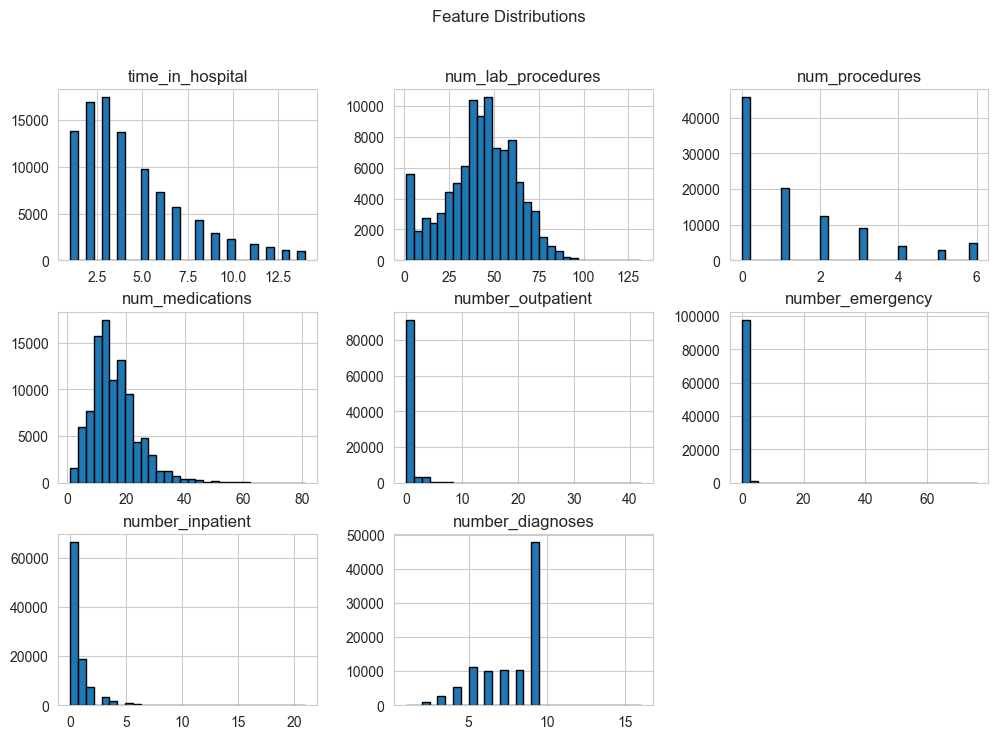

In [78]:
# Convert to Pandas
pdf = df.select(numeric_features).toPandas()

# Plot histograms
pdf.hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Feature Distributions")
plt.show()

### Boxplot (Detecting Outliers)

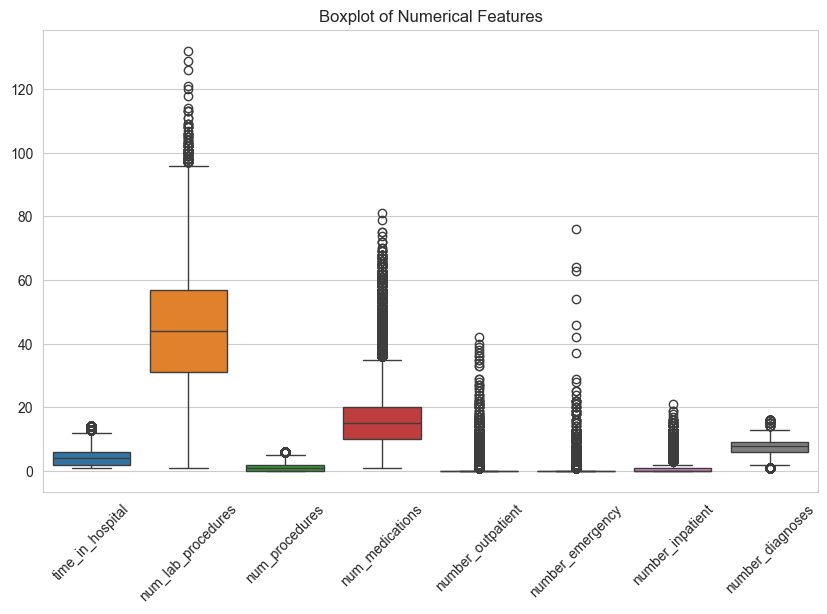

In [79]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pdf)
plt.xticks(rotation=45)
plt.title("Boxplot of Numerical Features")
plt.show()

### Bar Plot (Categorical Features)

<Figure size 800x400 with 0 Axes>

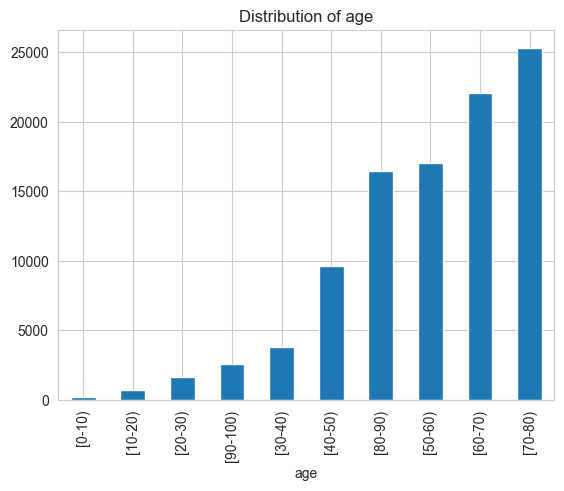

<Figure size 800x400 with 0 Axes>

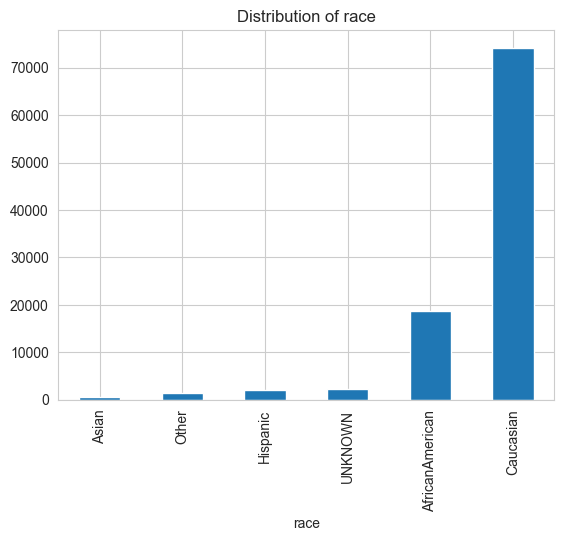

<Figure size 800x400 with 0 Axes>

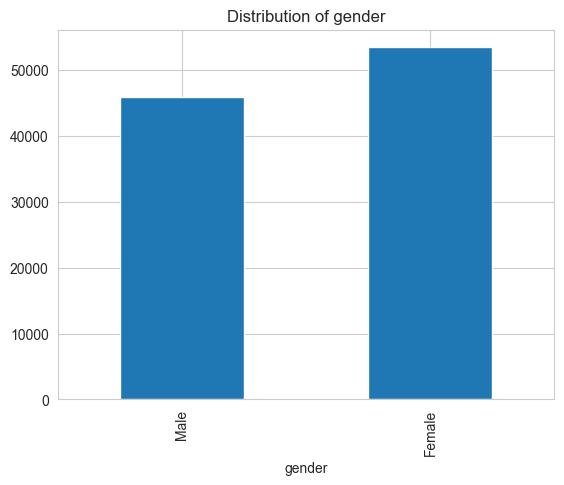

<Figure size 800x400 with 0 Axes>

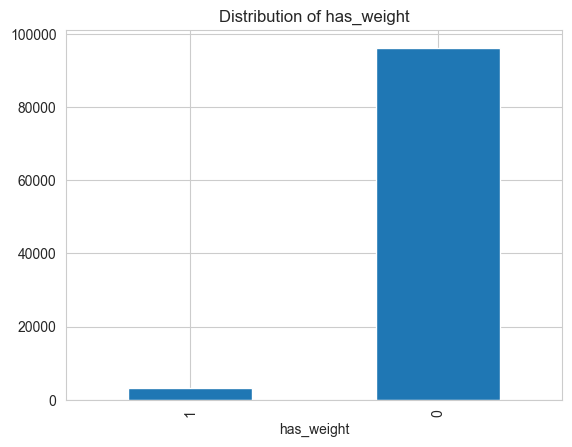

<Figure size 800x400 with 0 Axes>

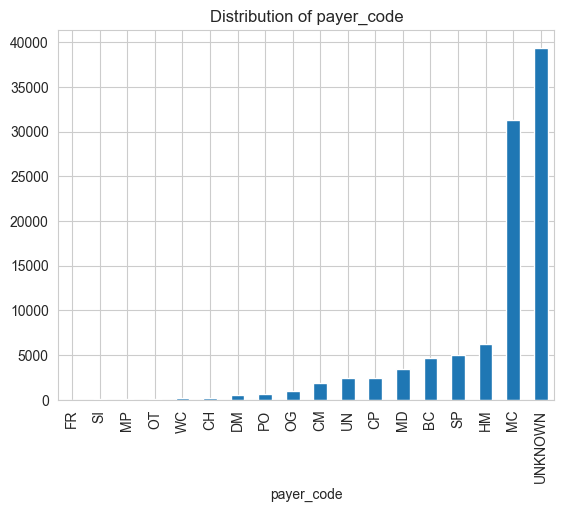

<Figure size 800x400 with 0 Axes>

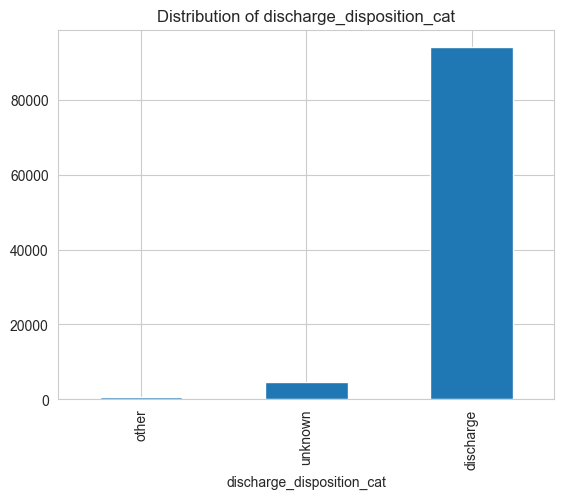

<Figure size 800x400 with 0 Axes>

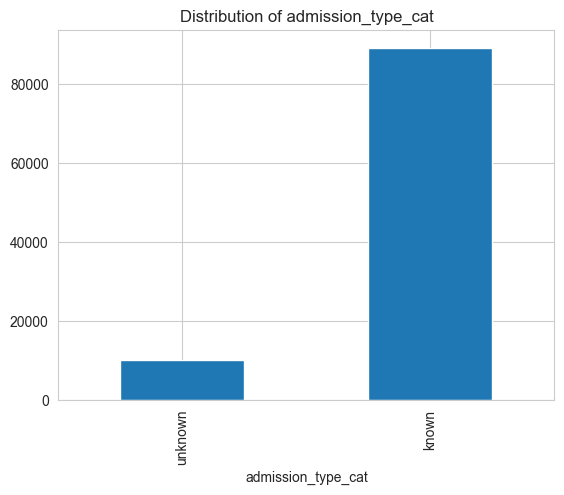

<Figure size 800x400 with 0 Axes>

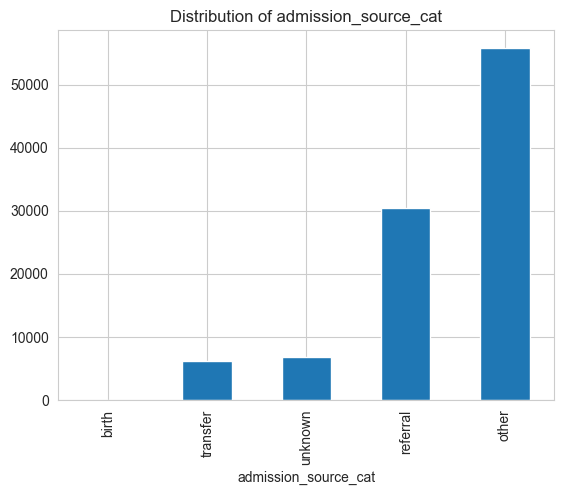

<Figure size 800x400 with 0 Axes>

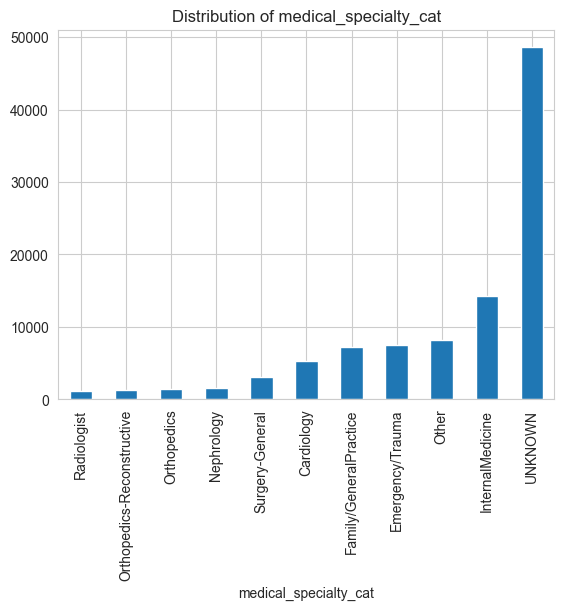

<Figure size 800x400 with 0 Axes>

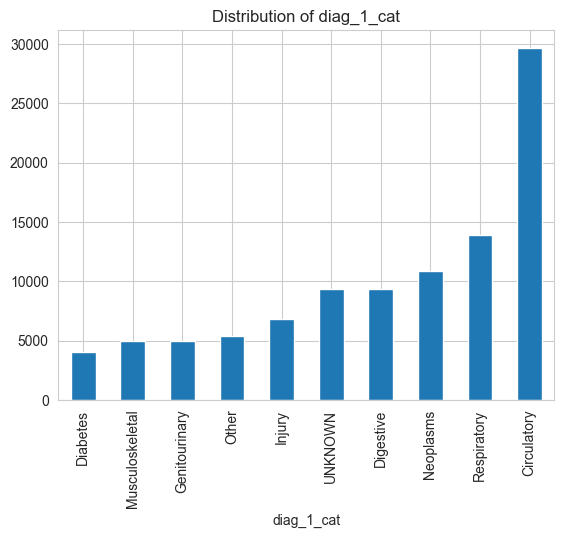

<Figure size 800x400 with 0 Axes>

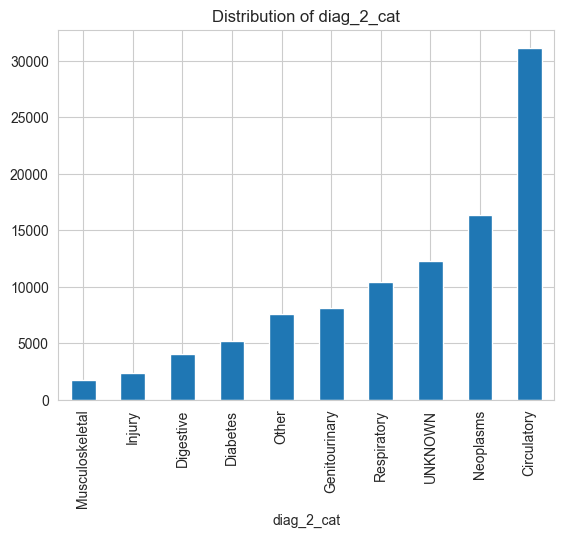

<Figure size 800x400 with 0 Axes>

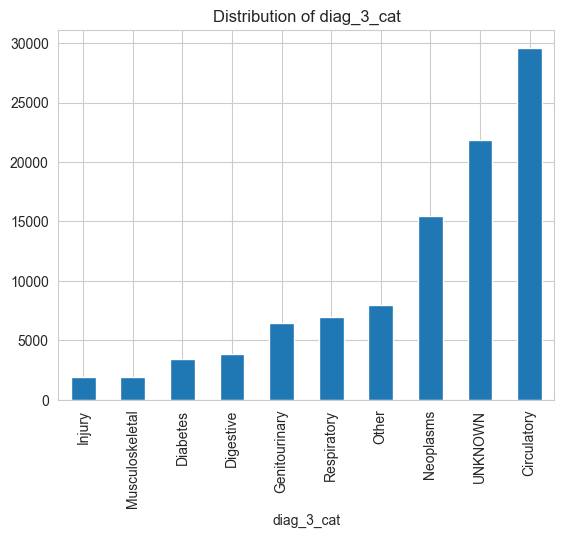

<Figure size 800x400 with 0 Axes>

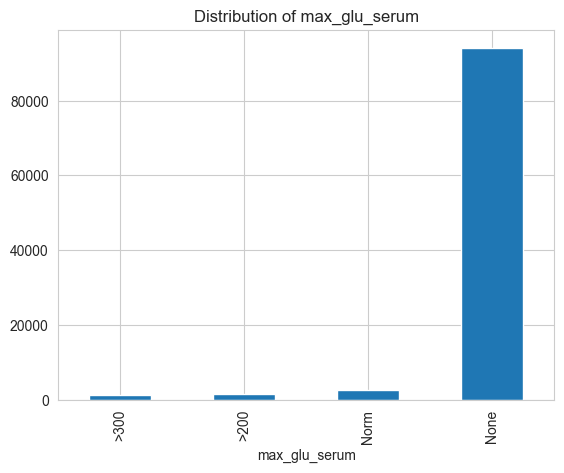

<Figure size 800x400 with 0 Axes>

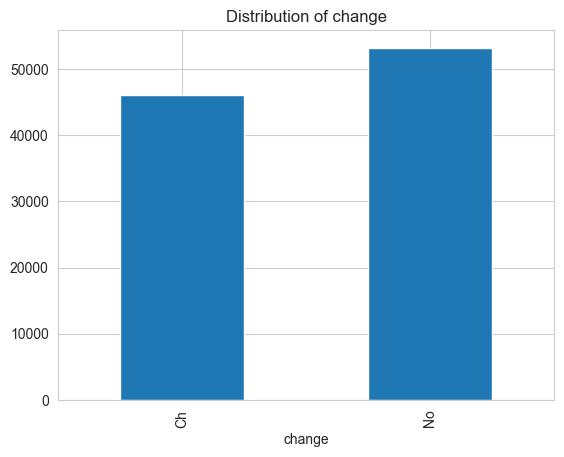

<Figure size 800x400 with 0 Axes>

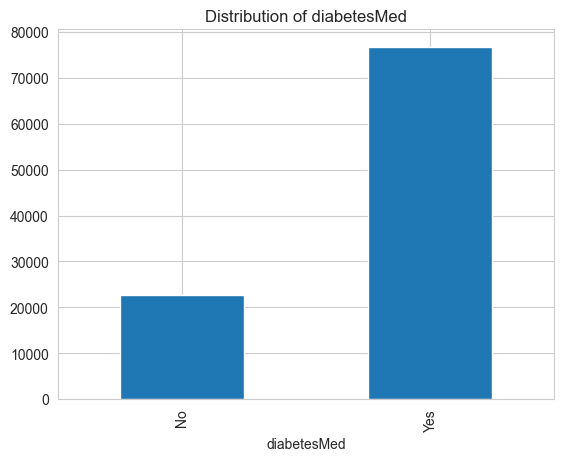

<Figure size 800x400 with 0 Axes>

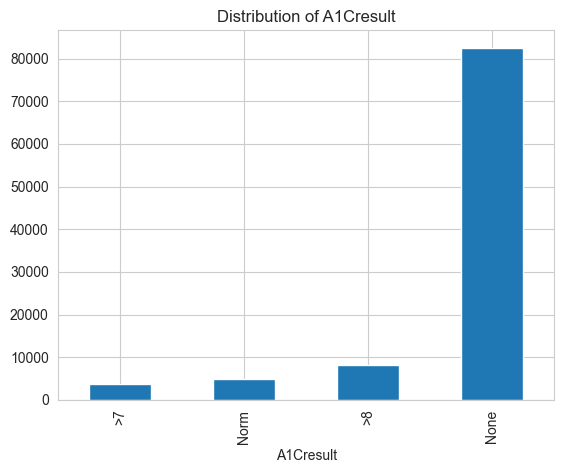

<Figure size 800x400 with 0 Axes>

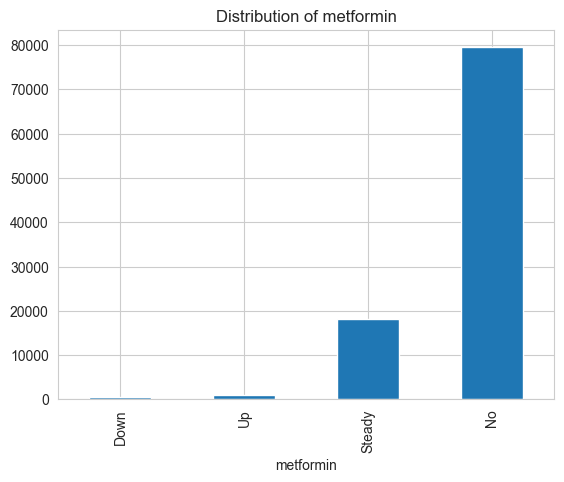

<Figure size 800x400 with 0 Axes>

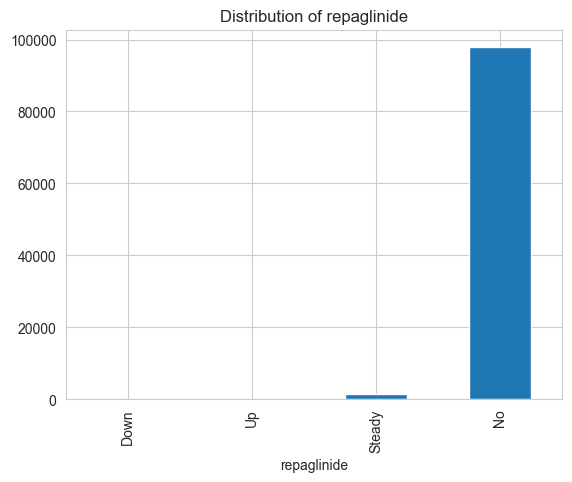

<Figure size 800x400 with 0 Axes>

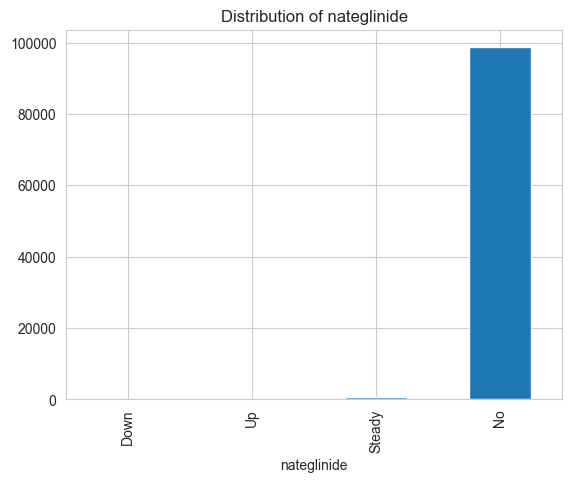

<Figure size 800x400 with 0 Axes>

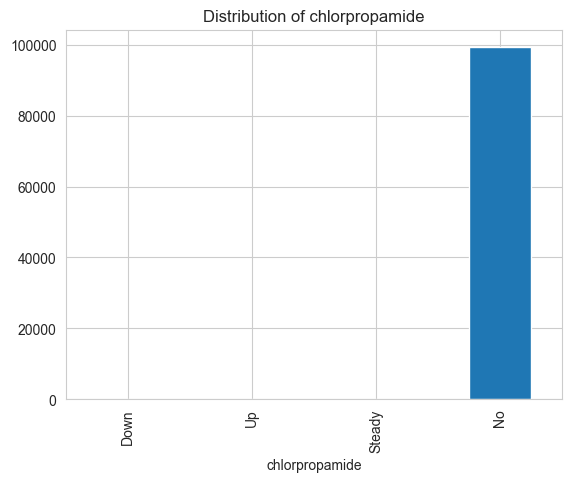

<Figure size 800x400 with 0 Axes>

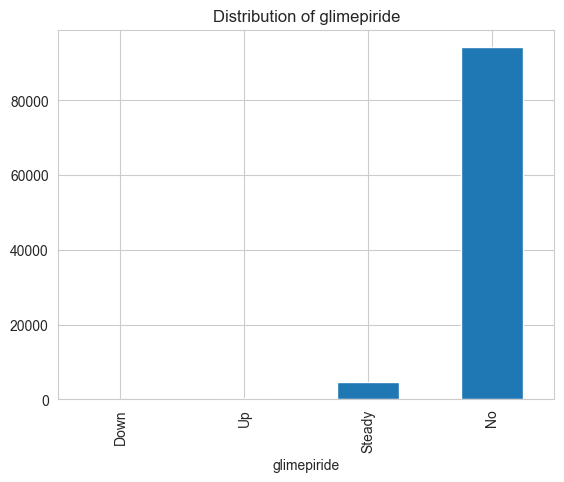

<Figure size 800x400 with 0 Axes>

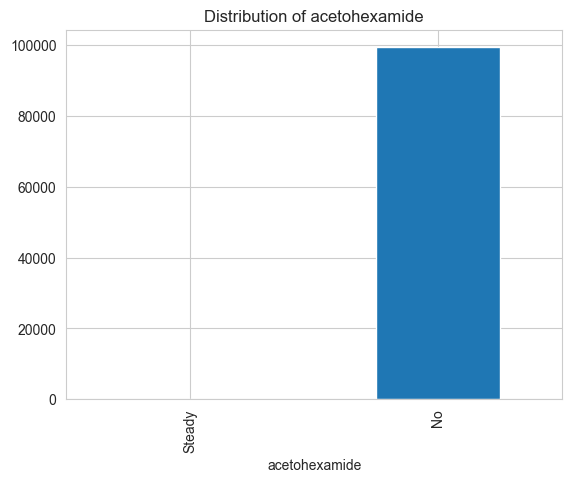

<Figure size 800x400 with 0 Axes>

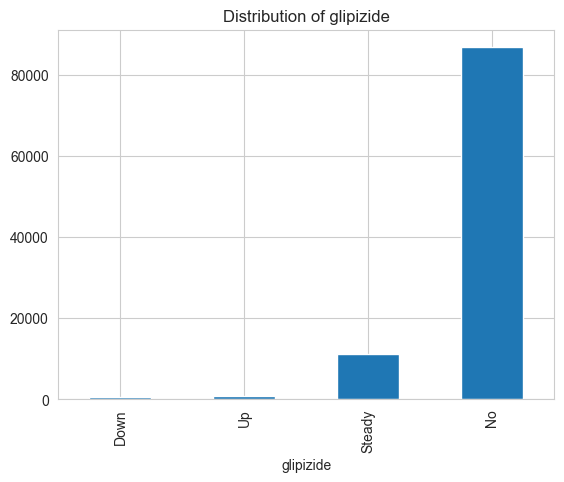

<Figure size 800x400 with 0 Axes>

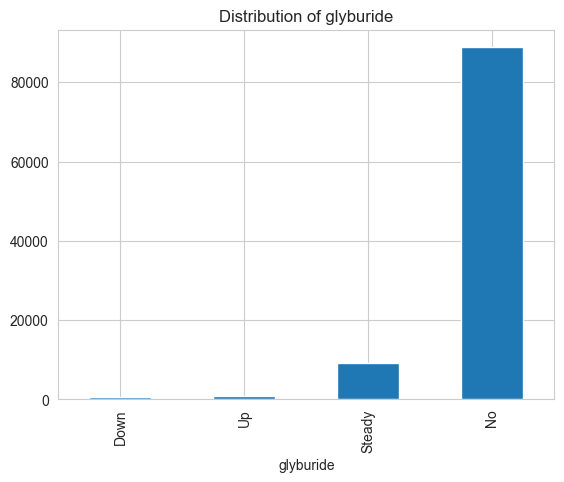

<Figure size 800x400 with 0 Axes>

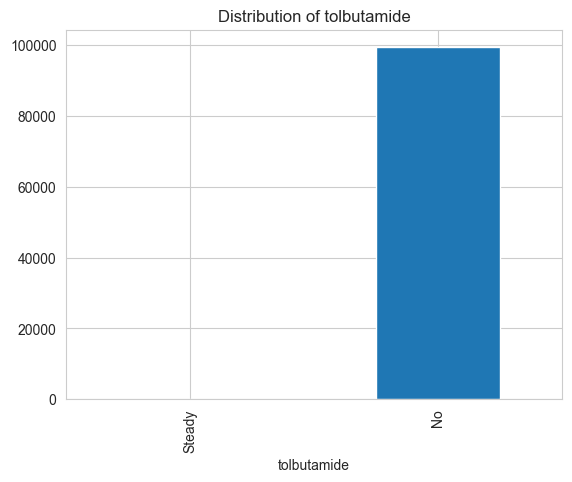

<Figure size 800x400 with 0 Axes>

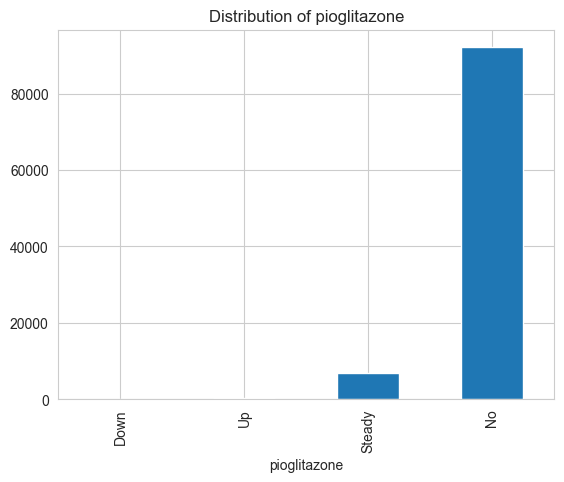

<Figure size 800x400 with 0 Axes>

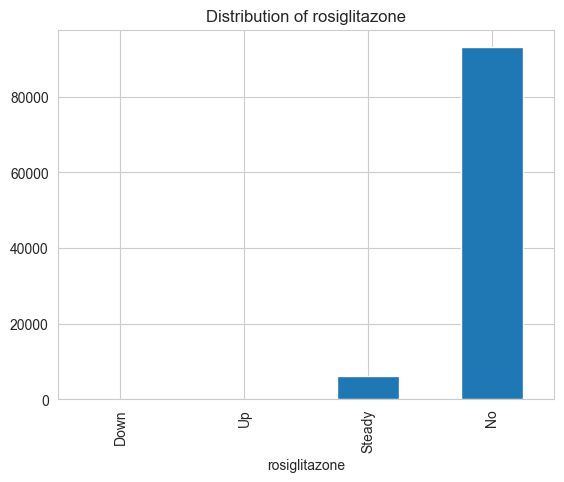

<Figure size 800x400 with 0 Axes>

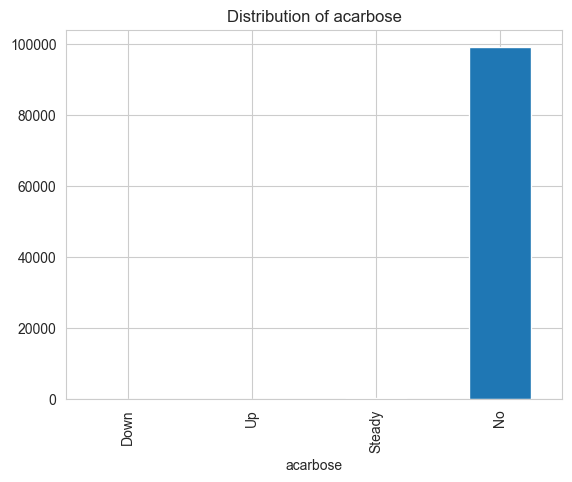

<Figure size 800x400 with 0 Axes>

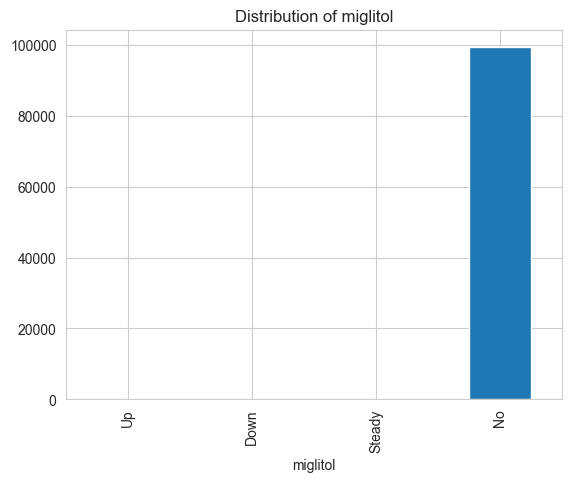

<Figure size 800x400 with 0 Axes>

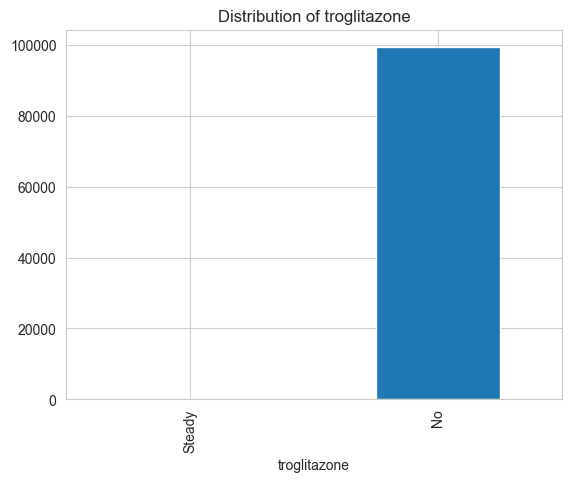

<Figure size 800x400 with 0 Axes>

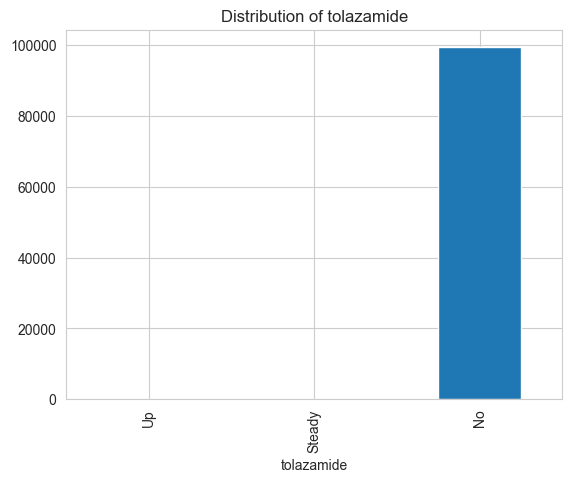

<Figure size 800x400 with 0 Axes>

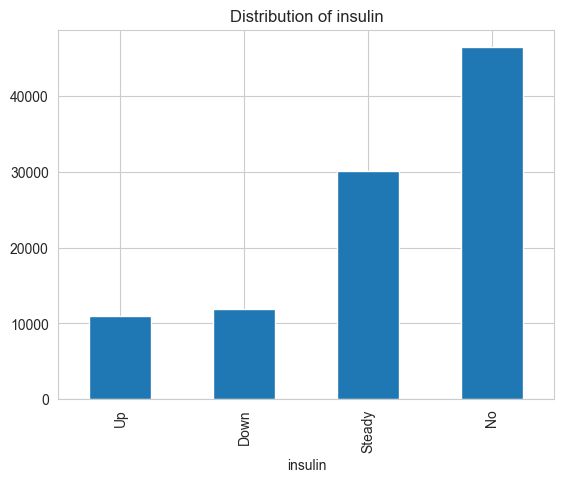

<Figure size 800x400 with 0 Axes>

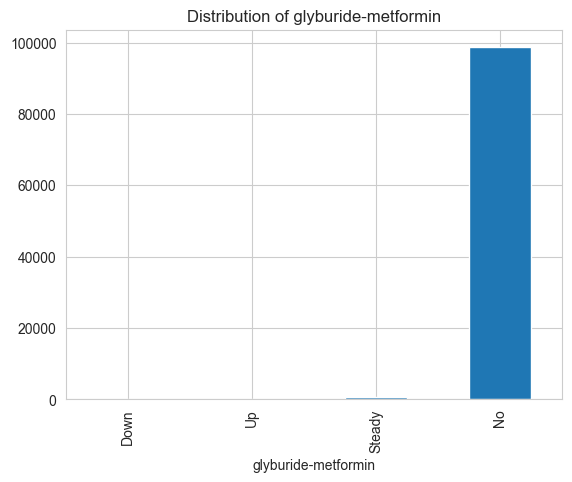

<Figure size 800x400 with 0 Axes>

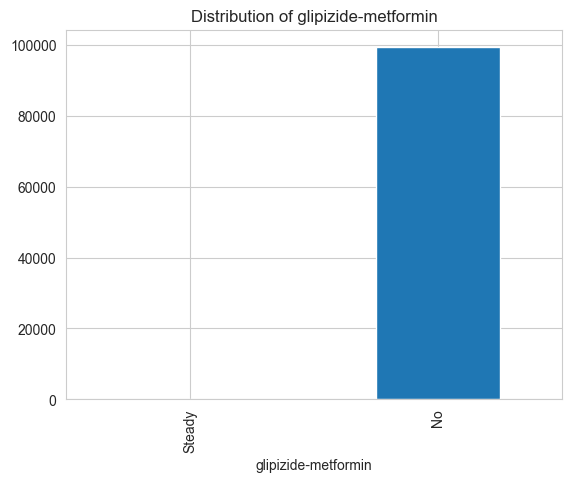

<Figure size 800x400 with 0 Axes>

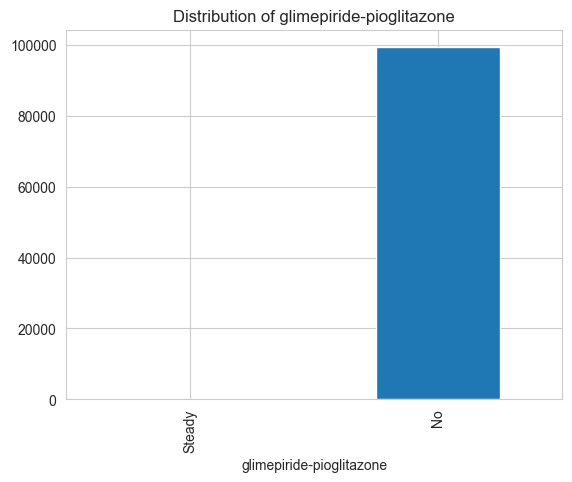

<Figure size 800x400 with 0 Axes>

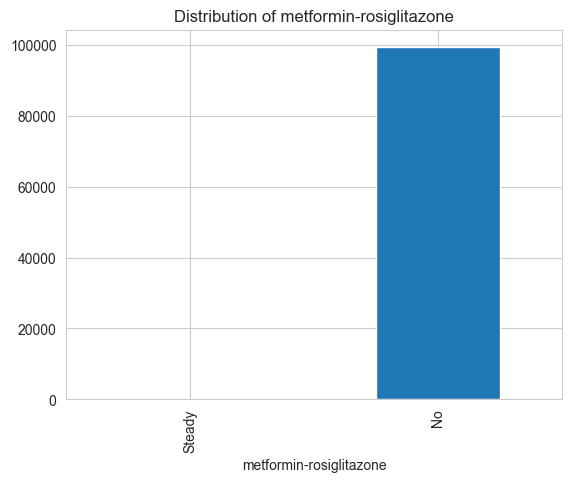

<Figure size 800x400 with 0 Axes>

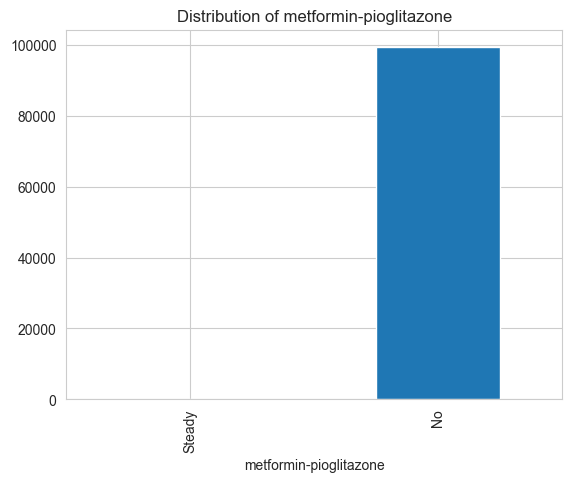

In [80]:
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    df.groupBy(col).count().toPandas().sort_values("count").plot(
        kind="bar", x=col, y="count", legend=False
    )
    plt.title(f"Distribution of {col}")
    plt.show()

The above code helps with understanding category frequencies.

In [81]:
target_col = "is_readmitted"  # Target variable

numerical_corr = {
    col: df.select(corr(col, target_col)).collect()[0][0] for col in numeric_features
}

# Display correlation results
for feature, value in numerical_corr.items():
    print(f"Correlation between {feature} and {target_col}: {value:.4f}")

Correlation between time_in_hospital and is_readmitted: 0.0579
Correlation between num_lab_procedures and is_readmitted: 0.0492
Correlation between num_procedures and is_readmitted: -0.0422
Correlation between num_medications and is_readmitted: 0.0529
Correlation between number_outpatient and is_readmitted: 0.0843
Correlation between number_emergency and is_readmitted: 0.1038
Correlation between number_inpatient and is_readmitted: 0.2253
Correlation between number_diagnoses and is_readmitted: 0.1242


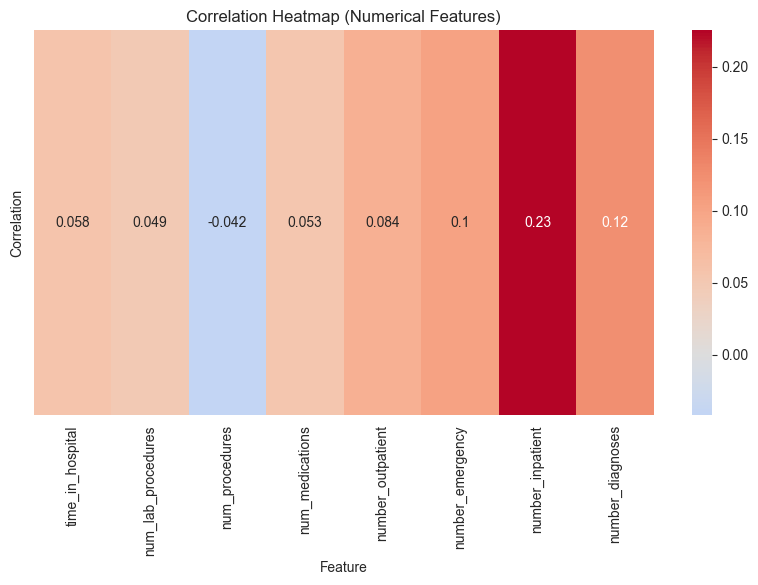

In [82]:
# Convert dictionary to DataFrame
corr_df = pd.DataFrame(list(numerical_corr.items()), columns=["Feature", "Correlation"])
corr_df.set_index("Feature", inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr_df.T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

In [83]:
def cramers_v(df, cat_col, target_col):
    """Calculate Cramér's V correlation between a categorical column and target"""
    indexed_col = cat_col + "_indexed"

    # Convert categorical feature to numerical
    indexer = StringIndexer(
        inputCol=cat_col, outputCol=indexed_col, handleInvalid="skip"
    )
    df_temp = indexer.fit(df).transform(df)

    # Compute contingency table
    contingency_table = df_temp.groupby(indexed_col, target_col).count().toPandas()

    # Pivot table
    pivot_table = contingency_table.pivot(
        index=indexed_col, columns=target_col, values="count"
    ).fillna(0)

    # Chi-square statistic
    from scipy.stats import chi2_contingency

    chi2, _, _, _ = chi2_contingency(pivot_table)

    # Compute Cramér's V
    n = df.count()
    k = min(pivot_table.shape) - 1
    cramers_v = float(np.sqrt(chi2 / (n * k)))

    return cramers_v


# Compute correlation for categorical features
cat_corr = {}
for col in categorical_features:
    cat_corr[col] = cramers_v(df, col, "is_readmitted")  # Ensure it's float

# Display results
for feature, value in cat_corr.items():
    print(f"Cramér's V correlation between {feature} and {target_col}: {value:.4f}")

Cramér's V correlation between age and is_readmitted: 0.0566
Cramér's V correlation between race and is_readmitted: 0.0546
Cramér's V correlation between gender and is_readmitted: 0.0174
Cramér's V correlation between has_weight and is_readmitted: 0.0451
Cramér's V correlation between payer_code and is_readmitted: 0.0738
Cramér's V correlation between discharge_disposition_cat and is_readmitted: 0.0243
Cramér's V correlation between admission_type_cat and is_readmitted: 0.0238
Cramér's V correlation between admission_source_cat and is_readmitted: 0.1039
Cramér's V correlation between medical_specialty_cat and is_readmitted: 0.0876
Cramér's V correlation between diag_1_cat and is_readmitted: 0.0589
Cramér's V correlation between diag_2_cat and is_readmitted: 0.0618
Cramér's V correlation between diag_3_cat and is_readmitted: 0.0636
Cramér's V correlation between max_glu_serum and is_readmitted: 0.0227
Cramér's V correlation between change and is_readmitted: 0.0429
Cramér's V correlation

In [84]:
# Threshold for correlation (adjust based on dataset)
correlation_threshold = 0.05

# Remove low-correlation numerical features
selected_numerical = [
    col for col, corr in numerical_corr.items() if abs(corr) > correlation_threshold
]

# Remove low-correlation categorical features
selected_categorical = [
    col for col, corr in cat_corr.items() if abs(corr) > correlation_threshold
]

print("Selected Numerical Features:", selected_numerical)
print("Selected Categorical Features:", selected_categorical)

Selected Numerical Features: ['time_in_hospital', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Selected Categorical Features: ['age', 'race', 'payer_code', 'admission_source_cat', 'medical_specialty_cat', 'diag_1_cat', 'diag_2_cat', 'diag_3_cat', 'diabetesMed', 'insulin']


---
# 6. Training Model

In [85]:
model_metrics = defaultdict(dict)

In [86]:
class ModelTrainer:
    def __init__(
        self,
        model,
        categorical_columns: List[str],
        numerical_columns: List[str],
        label_col: str,
        scaler: str = "standardize",
    ):
        self.model = model
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns
        self.label_col = label_col
        self.scaler = scaler
        self.pipeline_model = None
        self.pipeline = None

        self.prepare()

    def prepare(self):
        indexers = [
            StringIndexer(
                inputCol=c,
                outputCol=c + "_indexed",
                handleInvalid="keep",
            )
            for c in self.categorical_columns
        ]

        encoders = [
            OneHotEncoder(
                inputCol=indexer.getOutputCol(),
                outputCol=indexer.getOutputCol() + "_encoded",
                dropLast=False,
            )
            for indexer in indexers
        ]

        assembler = VectorAssembler(
            inputCols=[encoder.getOutputCol() for encoder in encoders]
            + self.numerical_columns,
            outputCol="features",
        )

        stages = indexers + encoders + [assembler]

        if self.scaler == "standardize":
            scaler = StandardScaler(
                inputCol="features",
                outputCol="scaled_features",
                withStd=True,
                withMean=True,
            )
            stages += [scaler]
        elif self.scaler == "normalize":
            scaler = Normalizer(inputCol="features", outputCol="scaled_features")
            stages += [scaler]
        else:
            pass

        stages += [self.model]

        self.pipeline = Pipeline(stages=stages)

    def fit(self, dataframe: pyspark.sql.DataFrame):
        self.pipeline_model = self.pipeline.fit(dataframe)

    def transform(self, dataframe: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
        data = self.pipeline_model.transform(dataframe)
        return data.withColumn("label", F.col(self.label_col))

    def fit_transform(self, dataframe: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
        self.fit(dataframe)
        return self.transform(dataframe)

In the above cell, I have created a class to set up the pipeline for the model training.

In [87]:
def print_model_summary(
    model_name: str,
    is_train: bool,
    evaluator: BinaryClassificationEvaluator,
    prediction: pyspark.sql.DataFrame,
    label_col: str = "label",
):
    # prediction_and_labels = prediction.select("rawPrediction", label_col).rdd.map(
    #     lambda row: (float(row[0][0]), float(row[1]))
    # )

    # metrics = BinaryClassificationMetrics(prediction_and_labels)

    print("Summary Stats")
    print(
        f"AreaUnderROC: {evaluator.evaluate(prediction, {evaluator.metricName: 'areaUnderROC'})}"
    )
    print(
        f"AreaUnderPR: {evaluator.evaluate(prediction, {evaluator.metricName: 'areaUnderPR'})}"
    )

    # compute TN, TP, FN, and FP
    prediction.groupBy(label_col, "prediction").count().show()

    # Calculate the elements of the confusion matrix
    TN = prediction.filter(f"prediction = 0 AND {label_col} = prediction").count()
    TP = prediction.filter(f"prediction = 1 AND {label_col} = prediction").count()
    FN = prediction.filter(f"prediction = 0 AND {label_col} <> prediction").count()
    FP = prediction.filter(f"prediction = 1 AND {label_col} <> prediction").count()

    # calculate accuracy, precision, recall, and F1-score
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    temp = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
    }
    model_metrics[model_name]["train" if is_train else "test"] = temp

    print("n precision: %0.3f" % precision)
    print("n recall: %0.3f" % recall)
    print("n accuracy: %0.3f" % accuracy)
    print("n F1 score: %0.3f" % f1_score)

In the above cell, I have written a code to print out a summary of the model given the prediction dataframe.

In [88]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In the code above, I split the dataframe into training and test sets.

In [89]:
categorical_features = selected_categorical
numerical_features = selected_numerical

In [90]:
train_df, removed_features = remove_features_with_one_distinct_values(
    train_df, categorical_features
)

for feature in removed_features:
    test_df = test_df.drop(feature)

In [91]:
test_df, removed_features = remove_features_with_one_distinct_values(
    test_df, categorical_features
)

for feature in removed_features:
    train_df = train_df.drop(feature)

In the above cells, I have checked for categorical columns with that have only one distinct value and removed them from the categorical columns list.

## Random Forest Classifier

In [92]:
random_forest_model = RandomForestClassifier(labelCol="is_readmitted")
random_forest_param_grid = (
    ParamGridBuilder()
    .addGrid(random_forest_model.maxDepth, [2, 4, 6, 8])
    .addGrid(random_forest_model.maxBins, [10, 50, 100])
    .build()
)
random_forest_trainer = ModelTrainer(
    model=random_forest_model,
    categorical_columns=categorical_features,
    numerical_columns=numeric_features,
    label_col="is_readmitted",
)

random_forest_evaluator = BinaryClassificationEvaluator(labelCol="is_readmitted")

random_forest_cv = CrossValidator(
    estimator=random_forest_trainer.pipeline,
    evaluator=random_forest_evaluator,
    estimatorParamMaps=random_forest_param_grid,
    numFolds=3,
    seed=42,
)
random_forest_cv_model = random_forest_cv.fit(train_df)

In [93]:
random_forest_train_pred = random_forest_cv_model.bestModel.transform(train_df)
print_model_summary(
    "random_forest",
    True,
    random_forest_evaluator,
    random_forest_train_pred,
    "is_readmitted",
)

Summary Stats


AreaUnderROC: 0.6868758886181856


AreaUnderPR: 0.6634590015394138


+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0|19620|
|            0|       0.0|32385|
|            1|       1.0|18035|
|            0|       1.0| 9597|
+-------------+----------+-----+



n precision: 0.653
n recall: 0.479
n accuracy: 0.633
n F1 score: 0.552


In [94]:
random_forest_test_pred = random_forest_cv_model.bestModel.transform(test_df)
print_model_summary(
    "random_forest",
    False,
    random_forest_evaluator,
    random_forest_test_pred,
    "is_readmitted",
)

Summary Stats
AreaUnderROC: 0.6728134426391721
AreaUnderPR: 0.6371629427753032
+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0| 4798|
|            0|       0.0| 8045|
|            1|       1.0| 4363|
|            0|       1.0| 2497|
+-------------+----------+-----+

n precision: 0.636
n recall: 0.476
n accuracy: 0.630
n F1 score: 0.545


In [95]:
list(
    zip(
        random_forest_cv_model.getEstimatorParamMaps(),
        random_forest_cv_model.avgMetrics,
    )
)

[({Param(parent='RandomForestClassifier_2927b8fc3f8c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='RandomForestClassifier_2927b8fc3f8c', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10},
  np.float64(0.6532331119197125)),
 ({Param(parent='RandomForestClassifier_2927b8fc3f8c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='RandomForestClassifier_2927b8fc3f8c', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 50},
  np.float64(0.6531111906662246)),
 ({Param(parent='RandomForestClassifier_2927b8fc3f8c', name='max

## GBT Classifier

In [96]:
gbt_model = GBTClassifier(labelCol="is_readmitted")
gbt_param_grid = (
    ParamGridBuilder()
    .addGrid(gbt_model.maxDepth, [2, 4, 6, 8])
    .addGrid(gbt_model.maxBins, [10, 50, 100])
    .build()
)
gbt_trainer = ModelTrainer(
    model=gbt_model,
    categorical_columns=categorical_features,
    numerical_columns=numeric_features,
    label_col="is_readmitted",
)

gbt_evaluator = BinaryClassificationEvaluator(labelCol="is_readmitted")

gbt_cv = CrossValidator(
    estimator=gbt_trainer.pipeline,
    evaluator=gbt_evaluator,
    estimatorParamMaps=gbt_param_grid,
    numFolds=3,
    seed=42,
)
gbt_cv_model = gbt_cv.fit(train_df)

In [97]:
gbt_train_pred = gbt_cv_model.bestModel.transform(train_df)
print_model_summary(
    "gbt",
    True,
    gbt_evaluator,
    gbt_train_pred,
    "is_readmitted",
)

Summary Stats
AreaUnderROC: 0.7025619841083577


AreaUnderPR: 0.680752058472512


+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0|17912|
|            0|       0.0|31542|
|            1|       1.0|19743|
|            0|       1.0|10440|
+-------------+----------+-----+



n precision: 0.654
n recall: 0.524
n accuracy: 0.644
n F1 score: 0.582


In [98]:
gbt_test_pred = gbt_cv_model.bestModel.transform(test_df)
print_model_summary(
    "gbt",
    False,
    gbt_evaluator,
    gbt_test_pred,
    "is_readmitted",
)

Summary Stats
AreaUnderROC: 0.6799329625427268
AreaUnderPR: 0.6436590637656413
+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0| 4436|
|            0|       0.0| 7767|
|            1|       1.0| 4725|
|            0|       1.0| 2775|
+-------------+----------+-----+

n precision: 0.630
n recall: 0.516
n accuracy: 0.634
n F1 score: 0.567


In [99]:
list(
    zip(
        gbt_cv_model.getEstimatorParamMaps(),
        gbt_cv_model.avgMetrics,
    )
)

[({Param(parent='GBTClassifier_0a93d0155c70', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='GBTClassifier_0a93d0155c70', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10},
  np.float64(0.6651598326043601)),
 ({Param(parent='GBTClassifier_0a93d0155c70', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='GBTClassifier_0a93d0155c70', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 50},
  np.float64(0.6650660284713213)),
 ({Param(parent='GBTClassifier_0a93d0155c70', name='maxDepth', doc='Maximum depth of the tree. (>= 0

## Decision Tree Classifier

In [100]:
decision_tree_model = DecisionTreeClassifier(labelCol="is_readmitted")
decision_tree_param_grid = (
    ParamGridBuilder()
    .addGrid(decision_tree_model.maxDepth, [2, 4, 6, 8])
    .addGrid(decision_tree_model.maxBins, [10, 50, 100])
    .build()
)
decision_tree_model_trainer = ModelTrainer(
    model=decision_tree_model,
    categorical_columns=categorical_features,
    numerical_columns=numeric_features,
    label_col="is_readmitted",
)

decision_tree_evaluator = BinaryClassificationEvaluator(
    labelCol="is_readmitted",
)

decision_tree_cv = CrossValidator(
    estimator=decision_tree_model_trainer.pipeline,
    evaluator=decision_tree_evaluator,
    estimatorParamMaps=decision_tree_param_grid,
    numFolds=3,
    seed=42,
)
decision_tree_cv_model = decision_tree_cv.fit(train_df)
# decision_tree_cv_model = cv.setParallelism(4).fit(train_df)

In [101]:
decision_tree_train_pred = decision_tree_cv_model.bestModel.transform(train_df)
print_model_summary(
    "decision_tree",
    True,
    decision_tree_evaluator,
    decision_tree_train_pred,
    "is_readmitted",
)

Summary Stats


AreaUnderROC: 0.4668757138368277
AreaUnderPR: 0.44651488293019137
+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0|19084|
|            0|       0.0|31993|
|            1|       1.0|18571|
|            0|       1.0| 9989|
+-------------+----------+-----+



n precision: 0.650
n recall: 0.493
n accuracy: 0.635
n F1 score: 0.561


In [102]:
decision_tree_test_pred = decision_tree_cv_model.bestModel.transform(test_df)
print_model_summary(
    "decision_tree",
    False,
    decision_tree_evaluator,
    decision_tree_test_pred,
    "is_readmitted",
)

Summary Stats
AreaUnderROC: 0.45924586774613146
AreaUnderPR: 0.4340378935062698
+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0| 4711|
|            0|       0.0| 7860|
|            1|       1.0| 4450|
|            0|       1.0| 2682|
+-------------+----------+-----+

n precision: 0.624
n recall: 0.486
n accuracy: 0.625
n F1 score: 0.546


In [103]:
list(
    zip(
        decision_tree_cv_model.getEstimatorParamMaps(),
        decision_tree_cv_model.avgMetrics,
    )
)

[({Param(parent='DecisionTreeClassifier_a5b141831e32', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='DecisionTreeClassifier_a5b141831e32', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10},
  np.float64(0.39519659423953196)),
 ({Param(parent='DecisionTreeClassifier_a5b141831e32', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='DecisionTreeClassifier_a5b141831e32', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 50},
  np.float64(0.39519659423953196)),
 ({Param(parent='DecisionTreeClassifier_a5b141831e32', name='m

## Linear SVC

In [104]:
linear_svc_model = LinearSVC(labelCol="is_readmitted")
linear_svc_param_grid = (
    ParamGridBuilder().addGrid(linear_svc_model.maxIter, [50, 100, 500, 1000]).build()
)
linear_svc_model_trainer = ModelTrainer(
    model=linear_svc_model,
    categorical_columns=categorical_features,
    numerical_columns=numeric_features,
    label_col="is_readmitted",
)

linear_svc_evaluator = BinaryClassificationEvaluator(
    labelCol="is_readmitted",
)

linear_svc_cv = CrossValidator(
    estimator=linear_svc_model_trainer.pipeline,
    evaluator=linear_svc_evaluator,
    estimatorParamMaps=linear_svc_param_grid,
    numFolds=3,
    seed=42,
)
linear_svc_cv_model = linear_svc_cv.fit(train_df)
# linear_svc_cv_model = cv.setParallelism(4).fit(train_df)

In [105]:
linear_svc_train_pred = linear_svc_cv_model.bestModel.transform(train_df)
print_model_summary(
    "linear_svc", True, linear_svc_evaluator, linear_svc_train_pred, "is_readmitted"
)

Summary Stats
AreaUnderROC: 0.6733857690690656


AreaUnderPR: 0.6472102060788546


+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0|25542|
|            0|       0.0|36634|
|            1|       1.0|12113|
|            0|       1.0| 5348|
+-------------+----------+-----+



n precision: 0.694
n recall: 0.322
n accuracy: 0.612
n F1 score: 0.440


In [106]:
linear_svc_test_pred = linear_svc_cv_model.bestModel.transform(test_df)
print_model_summary(
    "linear_svc",
    False,
    linear_svc_evaluator,
    linear_svc_test_pred,
    "is_readmitted",
)

Summary Stats
AreaUnderROC: 0.6739236337769398
AreaUnderPR: 0.6408639923677675
+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0| 6193|
|            0|       0.0| 9156|
|            1|       1.0| 2968|
|            0|       1.0| 1386|
+-------------+----------+-----+

n precision: 0.682
n recall: 0.324
n accuracy: 0.615
n F1 score: 0.439


In [107]:
list(zip(linear_svc_cv_model.getEstimatorParamMaps(), linear_svc_cv_model.avgMetrics))

[({Param(parent='LinearSVC_13f68f6a10e6', name='maxIter', doc='max number of iterations (>= 0).'): 50},
  np.float64(0.672049342589264)),
 ({Param(parent='LinearSVC_13f68f6a10e6', name='maxIter', doc='max number of iterations (>= 0).'): 100},
  np.float64(0.6720522385407532)),
 ({Param(parent='LinearSVC_13f68f6a10e6', name='maxIter', doc='max number of iterations (>= 0).'): 500},
  np.float64(0.6720506755984624)),
 ({Param(parent='LinearSVC_13f68f6a10e6', name='maxIter', doc='max number of iterations (>= 0).'): 1000},
  np.float64(0.6720550864400646))]

## Logistic Regression

In [108]:
lr_model = LogisticRegression(labelCol="is_readmitted")

lr_param_grid = (
    ParamGridBuilder()
    .addGrid(lr_model.threshold, [0.4, 0.5, 0.6])
    .addGrid(lr_model.maxIter, [50, 100, 500, 1000])
    .build()
)
lr_model_trainer = ModelTrainer(
    model=lr_model,
    categorical_columns=categorical_features,
    numerical_columns=numeric_features,
    label_col="is_readmitted",
)

lr_evaluator = BinaryClassificationEvaluator(
    labelCol="is_readmitted",
)

lr_cv = CrossValidator(
    estimator=lr_model_trainer.pipeline,
    evaluator=lr_evaluator,
    estimatorParamMaps=lr_param_grid,
    numFolds=3,
    seed=42,
)
lr_cv_model = lr_cv.fit(train_df)
# lr_cv_model = cv.setParallelism(4).fit(train_df)

In [109]:
lr_train_pred = lr_cv_model.bestModel.transform(train_df)
print_model_summary(
    "logistic_regression", True, lr_evaluator, lr_train_pred, "is_readmitted"
)

Summary Stats


AreaUnderROC: 0.6758223084915509


AreaUnderPR: 0.6487952930065377


+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0| 8053|
|            0|       0.0|18186|
|            1|       1.0|29602|
|            0|       1.0|23796|
+-------------+----------+-----+



n precision: 0.554
n recall: 0.786
n accuracy: 0.600
n F1 score: 0.650


In [110]:
lr_test_pred = lr_cv_model.bestModel.transform(test_df)
print_model_summary(
    "logistic_regression",
    False,
    lr_evaluator,
    lr_test_pred,
    "is_readmitted",
)

Summary Stats
AreaUnderROC: 0.6736685115076365
AreaUnderPR: 0.6399863317166206
+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0| 1896|
|            0|       0.0| 4441|
|            1|       1.0| 7265|
|            0|       1.0| 6101|
+-------------+----------+-----+

n precision: 0.544
n recall: 0.793
n accuracy: 0.594
n F1 score: 0.645


In [111]:
list(zip(lr_cv_model.getEstimatorParamMaps(), lr_cv_model.avgMetrics))

[({Param(parent='LogisticRegression_f63b72787616', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.4,
   Param(parent='LogisticRegression_f63b72787616', name='maxIter', doc='max number of iterations (>= 0).'): 50},
  np.float64(0.6734521104837558)),
 ({Param(parent='LogisticRegression_f63b72787616', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.4,
   Param(parent='LogisticRegression_f63b72787616', name='maxIter', doc='max number of iterations (>= 0).'): 100},
  np.float64(0.6734573416376471)),
 ({Param(parent='LogisticRegression_f63b72787616', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresh

## Naive Bayes

In [112]:
nb_model = NaiveBayes(labelCol="is_readmitted")

nb_param_grid = (
    ParamGridBuilder().addGrid(nb_model.smoothing, [0.4, 0.6, 0.8, 1.0]).build()
)
nb_model_trainer = ModelTrainer(
    model=nb_model,
    categorical_columns=categorical_features,
    numerical_columns=numeric_features,
    label_col="is_readmitted",
)

nb_evaluator = BinaryClassificationEvaluator(
    labelCol="is_readmitted",
)

nb_cv = CrossValidator(
    estimator=nb_model_trainer.pipeline,
    evaluator=nb_evaluator,
    estimatorParamMaps=nb_param_grid,
    numFolds=3,
    seed=42,
)
nb_cv_model = nb_cv.fit(train_df)
# nb_cv_model = cv.setParallelism(4).fit(train_df)

In [113]:
nb_train_pred = nb_cv_model.bestModel.transform(train_df)
print_model_summary("naive_bayes", True, nb_evaluator, nb_train_pred, "is_readmitted")

Summary Stats
AreaUnderROC: 0.4227204150907325


AreaUnderPR: 0.4174722867150656


+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0|20187|
|            0|       0.0|32109|
|            1|       1.0|17468|
|            0|       1.0| 9873|
+-------------+----------+-----+



n precision: 0.639
n recall: 0.464
n accuracy: 0.623
n F1 score: 0.538


In [114]:
nb_test_pred = nb_cv_model.bestModel.transform(test_df)
print_model_summary(
    "naive_bayes",
    False,
    nb_evaluator,
    nb_test_pred,
    "is_readmitted",
)

Summary Stats
AreaUnderROC: 0.4264297672834684
AreaUnderPR: 0.41189012749140536
+-------------+----------+-----+
|is_readmitted|prediction|count|
+-------------+----------+-----+
|            1|       0.0| 4872|
|            0|       0.0| 8046|
|            1|       1.0| 4289|
|            0|       1.0| 2496|
+-------------+----------+-----+

n precision: 0.632
n recall: 0.468
n accuracy: 0.626
n F1 score: 0.538


In [115]:
list(zip(nb_cv_model.getEstimatorParamMaps(), nb_cv_model.avgMetrics))

[({Param(parent='NaiveBayes_cff6115f38b3', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.4},
  np.float64(0.42270331206478234)),
 ({Param(parent='NaiveBayes_cff6115f38b3', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.6},
  np.float64(0.42270303323927916)),
 ({Param(parent='NaiveBayes_cff6115f38b3', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.8},
  np.float64(0.4227029556143182)),
 ({Param(parent='NaiveBayes_cff6115f38b3', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 1.0},
  np.float64(0.422699511418638))]

In [116]:
print(json.dumps(model_metrics, indent=4))

{
    "random_forest": {
        "train": {
            "accuracy": 0.6331227946808644,
            "precision": 0.6526852924145917,
            "recall": 0.47895365821272073,
            "f1_score": 0.5524836491185073
        },
        "test": {
            "accuracy": 0.6297518144445008,
            "precision": 0.63600583090379,
            "recall": 0.47625805043117564,
            "f1_score": 0.5446601335746832
        }
    },
    "gbt": {
        "train": {
            "accuracy": 0.6439845800318947,
            "precision": 0.6541099294304741,
            "recall": 0.5243128402602576,
            "f1_score": 0.5820631504466522
        },
        "test": {
            "accuracy": 0.6340151246003147,
            "precision": 0.63,
            "recall": 0.5157733871848051,
            "f1_score": 0.5671928455674929
        }
    },
    "decision_tree": {
        "train": {
            "accuracy": 0.6349309994098221,
            "precision": 0.6502450980392157,
            "recall

In [117]:
# spark.stop()